# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Solve-DHAMed-equations-for-biased-ensemble" data-toc-modified-id="Solve-DHAMed-equations-for-biased-ensemble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Solve DHAMed equations for biased ensemble</a></div><div class="lev2 toc-item"><a href="#Reconstruct-populations-from-relative-free-energies" data-toc-modified-id="Reconstruct-populations-from-relative-free-energies-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Reconstruct populations from relative free energies</a></div><div class="lev1 toc-item"><a href="#Analyze-long-reference-MD-simulations" data-toc-modified-id="Analyze-long-reference-MD-simulations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyze long reference MD simulations</a></div><div class="lev1 toc-item"><a href="#Compare-$p_i$-from-DHAMed-analysis-of-biased-simulations-and-long-reference-simulations" data-toc-modified-id="Compare-$p_i$-from-DHAMed-analysis-of-biased-simulations-and-long-reference-simulations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compare <span class="MathJax_Preview" style="color: inherit;"><span class="MJXp-math" id="MJXp-Span-1"><span class="MJXp-msubsup" id="MJXp-Span-2"><span class="MJXp-mi MJXp-italic" id="MJXp-Span-3" style="margin-right: 0.05em;">p</span><span class="MJXp-mi MJXp-italic MJXp-script" id="MJXp-Span-4" style="vertical-align: -0.4em;">i</span></span></span></span><span class="MathJax MathJax_Processing" id="MathJax-Element-1-Frame" tabindex="0"></span><script type="math/tex" id="MathJax-Element-1">p_i</script> from DHAMed analysis of biased simulations and long reference simulations</a></div><div class="lev1 toc-item"><a href="#References" data-toc-modified-id="References-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></div>

In [1]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pydhamed import count_matrix
from pydhamed import run_dhamed

Here I am analyzing trajectories run with two different force fields. The reweighted trajectories are compared to long reference unbiased MD trajectories.

# Solve DHAMed equations for biased ensemble

* Transition counts and biases for the different trajectories are loaded from pandas pickles.

* Calculation run data split into five blocks to estimate uncertainty. All data points are used to get the best estimate of the free energy landscape of Ala5.

In [2]:
dhamed_bl_ar = np.zeros((32,6))

for bl_i in range(1,7):
    if bl_i == 6:
        bl="blall"
    else:
        bl="bl{}".format(bl_i)
    print bl
    bias_l = pd.read_pickle(bl+"/list_bias_ar")
    trans_count_l = pd.read_pickle(bl+"/list_transition_counts")
    bias_ar = np.column_stack(bias_l)
    og = run_dhamed(trans_count_l, bias_ar)
    dhamed_bl_ar[:,bl_i-1] = og*-1

bl1
998
loglike-start 12422.8696432
12422.8696432
Optimization terminated successfully.
         Current function value: 12314.481719
         Iterations: 39
         Function evaluations: 47
         Gradient evaluations: 47
time elapsed 1.6099050045 s
bl2
832
loglike-start 11987.6561668
11987.6561668
Optimization terminated successfully.
         Current function value: 11853.752282
         Iterations: 41
         Function evaluations: 54
         Gradient evaluations: 54
time elapsed 0.857865810394 s
bl3
710
loglike-start 11747.8259855
11747.8259855
Optimization terminated successfully.
         Current function value: 11650.904460
         Iterations: 38
         Function evaluations: 49
         Gradient evaluations: 49
time elapsed 0.672173976898 s
bl4
772
loglike-start 12027.5797906
12027.5797906
Optimization terminated successfully.
         Current function value: 11863.721843
         Iterations: 39
         Function evaluations: 51
         Gradient evaluations: 51
time ela

In [3]:
np.column_stack(bias_l).shape # 32 states and 30 windows 

(32, 30)

## Reconstruct populations from relative free energies

In [4]:
p_ar = np.zeros((6,32))

for i, row in enumerate(dhamed_bl_ar.T):
    p_ar[i,:] = np.exp(-row) / (np.sum(np.exp(-1*row)))

In [5]:
dh_err =np.std(p_ar[:-1],axis=0) / np.sqrt(4)
dh_log_err = np.std(-np.log(p_ar[:-1,:]),axis=0) / np.sqrt(4)

# Analyze long reference MD simulations

In [6]:
from pydhamed import block_average_pop_eq_tba,  pop_from_tba_eq_traj

In [7]:
tba1 = np.load("ref_unbiased_md/r1_5ala_1us_tba.npy")
tba2 = np.load("ref_unbiased_md/r2_5ala_1us_tba.npy")
tba3 = np.load("ref_unbiased_md/r3_5ala_1us_tba.npy")
md_tba = np.hstack((tba1[1:], tba2[1:], tba3[1:]))

In [8]:
nblocks_md = 5
md_bl = block_average_pop_eq_tba(md_tba, nblocks_md) # 3000 / 60 = 50 

md_err = np.std((md_bl), axis=1) / np.sqrt(nblocks_md-1.0)
md_log_err = np.std(-np.log(md_bl), axis=1) / np.sqrt(nblocks_md-1.0)

md_p = pop_from_tba_eq_traj(md_tba)

# Compare $p_i$ from DHAMed analysis of biased simulations and long reference simulations

The equilibrium populations determined from the biased simulations using DHAMed agree well with the long reference simulations.

[]

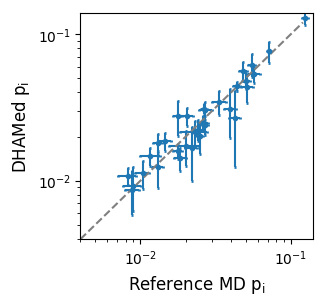

In [10]:
fig, ax = plt.subplots(figsize=(3,3))
#sns.set_style('ticks')
plt.errorbar(md_p, p_ar[-1,:], yerr=dh_err, xerr=md_err, fmt=".",
            capsize=1, capthick=2)
plt.plot([0.004,0.12], [0.004,0.12], "--", c='grey')
plt.ylim(0.004,0.14)
plt.xlim(0.004,0.14)
plt.ylabel("DHAMed $\mathrm{p_i}$", fontsize=12)
plt.xlabel("Reference MD $\mathrm{p_i}$", fontsize=12)
plt.loglog()

Look at the populations of individual structural states. For this I label the different structural states. E.g., 10000 means that the N-terminal residue is in a helical-like conformation and the other residues are in coil-like conformations. 

In [11]:
states_ordered = np.array([
        [0,0,0,0,0],
        [0,0,0,0,1],
        [0,0,0,1,0],
        [0,0,0,1,1],
        [0,0,1,0,0],
        [0,0,1,0,1],
        [0,0,1,1,0],
        [0,0,1,1,1],
        [0,1,0,0,0],
        [0,1,0,0,1],
        [0,1,0,1,0],
        [0,1,0,1,1],
        [0,1,1,0,0],
        [0,1,1,0,1],
        [0,1,1,1,0],
        [0,1,1,1,1],
        [1,0,0,0,0],
        [1,0,0,0,1],
        [1,0,0,1,0],
        [1,0,0,1,1],
        [1,0,1,0,0],
        [1,0,1,0,1],
        [1,0,1,1,0],
        [1,0,1,1,1],
        [1,1,0,0,0],
        [1,1,0,0,1],
        [1,1,0,1,0],
        [1,1,0,1,1],
        [1,1,1,0,0],
        [1,1,1,0,1],
        [1,1,1,1,0],
        [1,1,1,1,1]
    ])

str_label = [ "{}{}{}{}{}".format(*row)  for row in states_ordered]
xl = np.array([int(s, 2) for s in str_label])

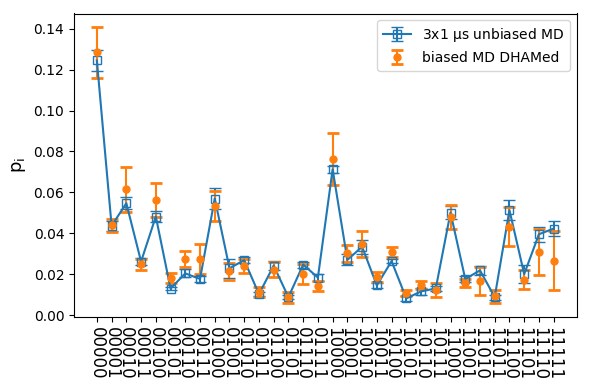

In [17]:
st_i = np.arange(1,33)
try:
    sns.set_style("ticks")
except:
    pass

plt.errorbar(st_i, md_p, yerr=md_err, capsize=4, capthick=2, label=r"3x1 $\mathrm{\mu s}$ unbiased MD", fmt="s-",
            mfc="None", mew=1)
plt.errorbar(st_i, p_ar[-1,:], yerr=dh_err, capsize=4, capthick=2, label="biased MD DHAMed", fmt="o", ms=5)
plt.ylabel(r"$\mathrm{p_i}$", fontsize=13)
#plt.xlabel("State", fontsize=13)

plt.xticks(xl+1, str_label, rotation=-90, fontsize=12);
ax.tick_params(axis='both', which='both', top=True, right=True)

plt.tight_layout()

plt.legend()

In [18]:
# use Seaborn color scheme. I don't load the Seaborn module so as not to introduce an extra dependency. 
cl = np.array([[2.980392156862745057e-01, 4.470588235294117863e-01, 6.901960784313725394e-01],
[3.333333333333333148e-01, 6.588235294117646967e-01, 4.078431372549019551e-01],
[7.686274509803922017e-01, 3.058823529411764941e-01, 3.215686274509804154e-01],
[5.058823529411764497e-01, 4.470588235294117863e-01, 6.980392156862744724e-01]])

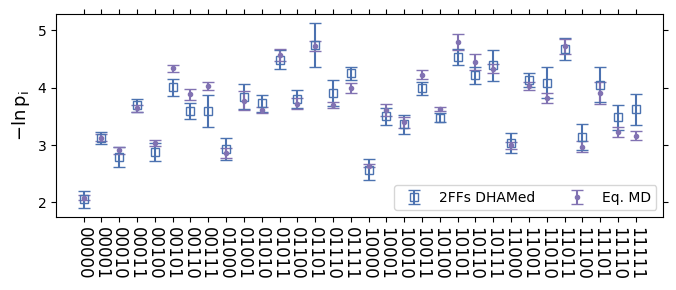

In [15]:
fig, ax = plt.subplots(figsize=(7,3))
try:
    sns.set_style("ticks")
except:
    pass
plt.errorbar(st_i, -1*np.log(p_ar[-1,:]), yerr=dh_log_err, capsize=4, capthick=2, c=cl[0], label="2FFs DHAMed" , fmt="s", mfc="None", mew=1.0, ms=6)
 

plt.errorbar(st_i, -1*np.log(md_p), yerr=md_log_err, capsize=4, capthick=2, c=cl[3], fmt=".", mew=1.0, ms=6,
            label="Eq. MD")

plt.legend(ncol=3)
plt.ylabel("$\mathrm{ - \ln \, p_i}$", fontsize=13)
plt.xticks(xl+1, str_label, rotation=-90, fontsize=12);
ax.tick_params(axis='both', which='both', top=True, right=True)

plt.tight_layout()

The plot reproduces Figure 8 of the manuscript [1].

# References

[1] Dynamic Histogram Analysis To Determine Free Energies and Rates from biased 
Simulations, L. S. Stelzl, A. Kells, E. Rosta, G. Hummer, J. Chem. Theory Comput.,
2017, http://pubs.acs.org/doi/abs/10.1021/acs.jctc.7b00373